# 导入官方库训练

In [1]:
import warnings
warnings.filterwarnings("ignore")

# preprocess
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

# model
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# socre
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score, auc

# figure
import matplotlib.pyplot as plt

# 定义辅助函数

In [2]:
# 训练的辅助函数
def trainHelper(model, x_train, y_train):
    print("=== train ===")
    start = time.time()
    model.fit(x_train, y_train)
    trainingTime = time.time() - start
    print("Training time: ", trainingTime, "sec\n")
    return model, trainingTime


# 推理的辅助函数
def inferenceHelper(model, x_test, y_test):
    print("=== inference ===")
    start_time_inference = time.time()
    y_pred = model.predict(x_test)
    inference_time = time.time() - start_time_inference
    # 计算F1, precision和recall
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print("F1 Score: ", f1)
    print("precision: ", precision)
    print("recall: ", recall)
    print(f"Inference Time: {inference_time} sec\n")

    return f1,precision,recall,inference_time


# gridSearch的辅助函数
def gridSearchHelper(model, p_grid, x_train, y_train):
    print("=== grid search ===")
    grid_search = GridSearchCV(estimator=model, param_grid=p_grid, scoring="f1", cv=5)
    start = time.time()
    grid_search.fit(x_train, y_train)
    searchTime = time.time() - start
    print("grid search time: ", searchTime, "sec\n")
    return grid_search.best_params_, searchTime


def plot_PRC(model, x_test, y_test):
    y_score = model.predict_proba(x_test)

    # 计算精确率和召回率和AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_score[:, 1])
    average_precision = average_precision_score(y_test, y_score[:, 1])
    print("AUPRC:", average_precision)

    # 绘制PRC曲线
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

    return average_precision

def printAsTable(origin_data, accelerate_data):
    print("{:<10} {:<15} {:<15}".format('Model', 'origin', 'oneAPI'))
    print("-" * 40)

    models = ['LR', 'DT', 'RF', 'SVM', 'KNN']
    for i in range(len(models)):
        print("{:<10} {:<15.4f} {:<15.4f}".format(models[i], origin_data[i], accelerate_data[i]))

def plotCompareTime(title, origin, accelerated):
    save_path = "full/" + title + ".png"
    unit_1 = [1,1,1,1,1]
    bar_width = 0.35
    opacity = 0.8
    algorithms = ['LR', 'DT', 'RF', 'SVM', 'KNN']
    speedup = [o/a for o, a in zip(origin, accelerated)]
    fig, ax = plt.subplots(figsize=(8,8))

    rects1 = ax.bar(np.arange(len(unit_1)), unit_1, bar_width,
                    alpha=opacity, color='#1893aa', align='center')
    rects2 = ax.bar(np.arange(len(speedup)) + bar_width, speedup, bar_width,
                    alpha=opacity, color='#225fe2', align='center')

    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Speedup Ratio')
    ax.set_title(title + ' Comparison: origin/oneAPI')
    # ax.set_xticks(x)
    ax.set_xticks(np.arange(len(unit_1)) + bar_width / 2)
    ax.set_xticklabels(algorithms)
    ax.legend((rects1[0], rects2[0]), ('origin', 'oneAPI'))

    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


def plotCompareScore(title, origin, accelerated):
    save_path = "full/" + title + ".png" 
    unit_1 = [1,1,1,1,1]
    bar_width = 0.35
    opacity = 0.8
    algorithms = ['LR', 'DT', 'RF', 'SVM', 'KNN']
    speedup = [a/o for o, a in zip(origin, accelerated)]
    fig, ax = plt.subplots(figsize=(8,8))

    rects1 = ax.bar(np.arange(len(unit_1)), unit_1, bar_width,
                    alpha=opacity, color='#1893aa', align='center')
    rects2 = ax.bar(np.arange(len(speedup)) + bar_width, speedup, bar_width,
                    alpha=opacity, color='#225fe2', align='center')

    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Speedup Ratio')
    ax.set_title(title + ' Comparison: origin/oneAPI')
    # ax.set_xticks(x)
    ax.set_xticks(np.arange(len(unit_1)) + bar_width / 2)
    ax.set_xticklabels(algorithms)
    ax.legend((rects1[0], rects2[0]), ('origin', 'oneAPI'))

    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    

# 训练过程
1. 读入csv数据，去除无关列Time
2. 训练时**使用原始数据集，不进行重采样平衡样本**
3. 预测时，使用原始数据集  

In [3]:
print("loading data...")
data = pd.read_csv('creditcard.csv')
data = data.drop(columns=['Time'], axis=1)
# Amount列值缩放到[-1,1]区间
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
x = data.drop(columns=['Class'], axis=1) 
y = data['Class']

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.3, random_state=42)
print("loading complete!")


loading data...
loading complete!


2. 使用不同算法训练并预测
   
   2.1. 逻辑回归

logistic regression:
=== train ===
Training time:  1.2785835266113281 sec

=== inference ===
F1 Score:  0.7296137339055795
precision:  0.8762886597938144
recall:  0.625
Inference Time: 0.020456552505493164 sec

AUPRC: 0.7907334636727787


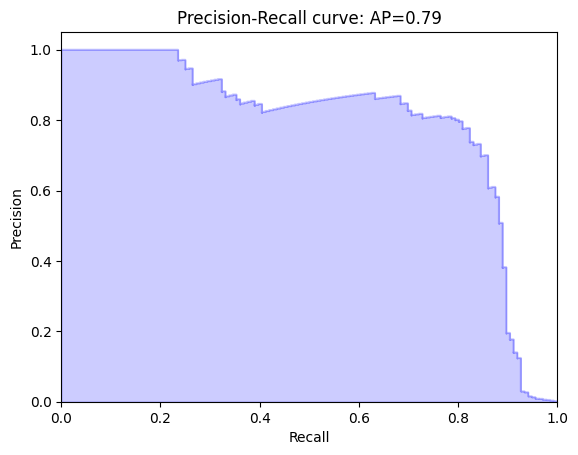

In [4]:
print("logistic regression:")
# 使用默认参数
LR_model = LogisticRegression()
LR_model, training_time_LR = trainHelper(LR_model,x_train, y_train)
f1_LR,precision_LR,recall_LR,inference_time_LR  = inferenceHelper(LR_model, x_test, y_test)
auprc_LR = plot_PRC(LR_model, x_test, y_test)


2.2 决策树

decision tree:
=== train ===
Training time:  17.70580220222473 sec

=== inference ===
F1 Score:  0.7659574468085105
precision:  0.7397260273972602
recall:  0.7941176470588235
Inference Time: 0.02210712432861328 sec

AUPRC: 0.587757196194233


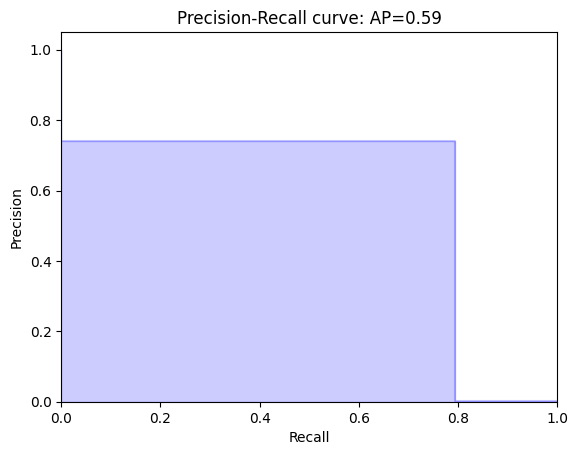

In [5]:
print("decision tree:")
# 使用默认参数
DT_model = DecisionTreeClassifier()
DT_model, training_time_DT = trainHelper(DT_model, x_train, y_train)
f1_DT, precision_DT, recall_DT,inference_time_DT  = inferenceHelper(DT_model, x_test, y_test)
auprc_DT = plot_PRC(DT_model, x_test, y_test)


2.3 随机森林

Random Forest Classifier
=== train ===
Training time:  186.41770839691162 sec

=== inference ===
F1 Score:  0.8685258964143425
precision:  0.9478260869565217
recall:  0.8014705882352942
Inference Time: 0.6041185855865479 sec

AUPRC: 0.8612140547965992


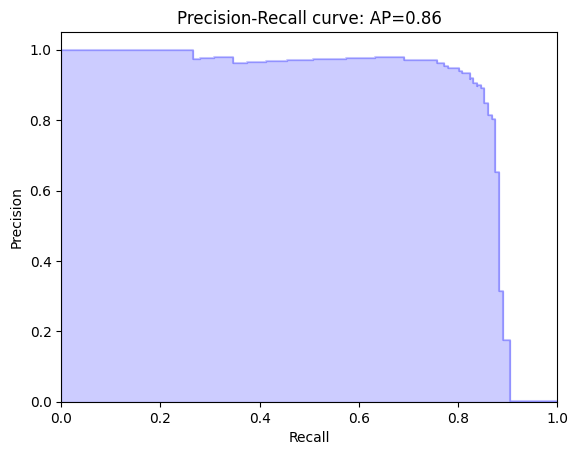

In [6]:
print("Random Forest Classifier")
# 使用默认参数
RF_model = RandomForestClassifier()
RF_model, training_time_RF = trainHelper(RF_model, x_train, y_train)
f1_RF, precision_RF, recall_RF,inference_time_RF  = inferenceHelper(RF_model, x_test, y_test)
auprc_RF = plot_PRC(RF_model, x_test, y_test)

2.4 SVM

Support vector machine
=== train ===
Training time:  1202.9602897167206 sec

=== inference ===
F1 Score:  0.8685258964143425
precision:  0.9478260869565217
recall:  0.8014705882352942
Inference Time: 0.6037893295288086 sec

AUPRC: 0.8437921836685026


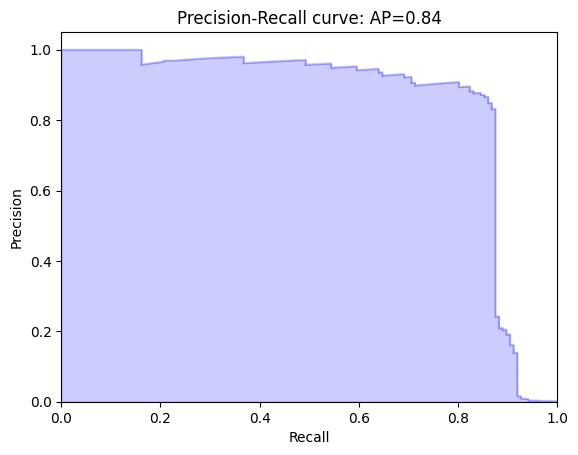

In [7]:
print("Support vector machine")
# 使用默认参数
SVM_model = SVC(probability=True)
SVM_model, training_time_SVM = trainHelper(SVM_model, x_train, y_train)
f1_SVM, precision_SVM, recall_SVM, inference_time_SVM  = inferenceHelper(RF_model, x_test, y_test)
auprc_SVM = plot_PRC(SVM_model, x_test, y_test)

2.5 KNN

=== train ===
Training time:  0.05814003944396973 sec

=== inference ===
F1 Score:  0.823529411764706
precision:  0.8823529411764706
recall:  0.7720588235294118
Inference Time: 11.020904302597046 sec

AUPRC: 0.820970977373372


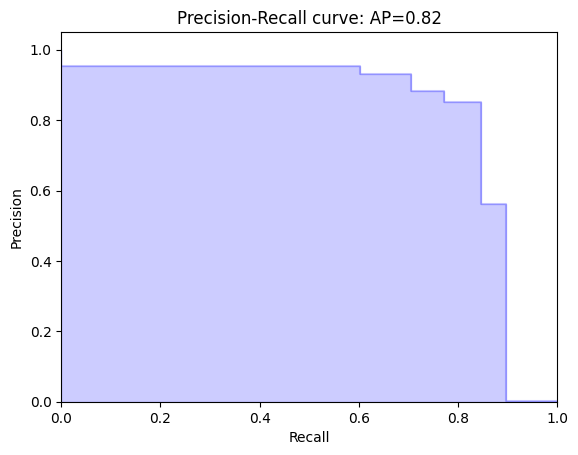

In [8]:
# 使用默认参数
KNN_model = KNeighborsClassifier()
KNN_model, training_time_KNN = trainHelper(KNN_model, x_train, y_train)
f1_KNN, precision_KNN, recall_KNN,inference_time_KNN  = inferenceHelper(KNN_model, x_test, y_test)
auprc_KNN = plot_PRC(KNN_model, x_test, y_test)

# 以下使用oneAPI库加速

In [9]:
import modin.pandas as pd
import modin.config as cfg
cfg.StorageFormat.put('hdk')
from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings("ignore")

# preprocess
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample

# model
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


# socre
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, precision_score, recall_score, auc

# figure
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 读取和预处理数据

In [10]:
print("loading data...")
data = pd.read_csv('creditcard.csv')
data = data.drop(columns=['Time'], axis=1)
# Amount列值缩放到[-1,1]区间
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
x = data.drop(columns=['Class'], axis=1) 
y = data['Class']

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.5, random_state=42)

print("loading complete!")


loading data...
loading complete!


2.1 逻辑回归

logistic regression:
=== train ===
Training time:  0.33760499954223633 sec

=== inference ===
F1 Score:  0.727710843373494
precision:  0.893491124260355
recall:  0.6138211382113821
Inference Time: 0.007100343704223633 sec

AUPRC: 0.769368207695428


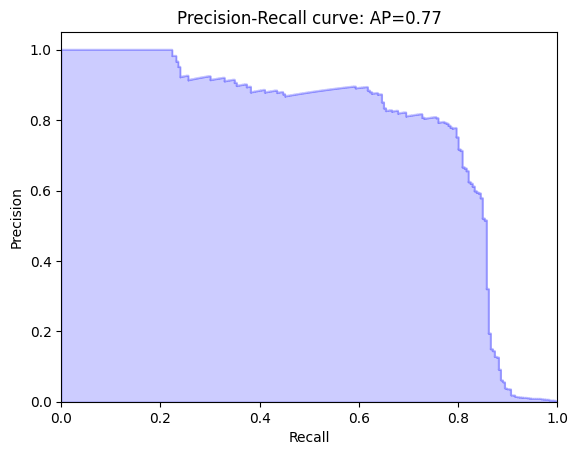

In [11]:
print("logistic regression:")
# 使用默认参数
LR_model = LogisticRegression()
LR_model, training_time_LR_a = trainHelper(LR_model,x_train, y_train)
f1_LR_a, precision_LR_a, recall_LR_a, inference_time_LR_a  = inferenceHelper(LR_model, x_test, y_test)
auprc_LR_a = plot_PRC(LR_model, x_test, y_test)

2.2 决策树

decision tree:
=== train ===
Training time:  13.176068782806396 sec

=== inference ===
F1 Score:  0.7359667359667359
precision:  0.7531914893617021
recall:  0.7195121951219512
Inference Time: 0.014397621154785156 sec

AUPRC: 0.5424149988090192


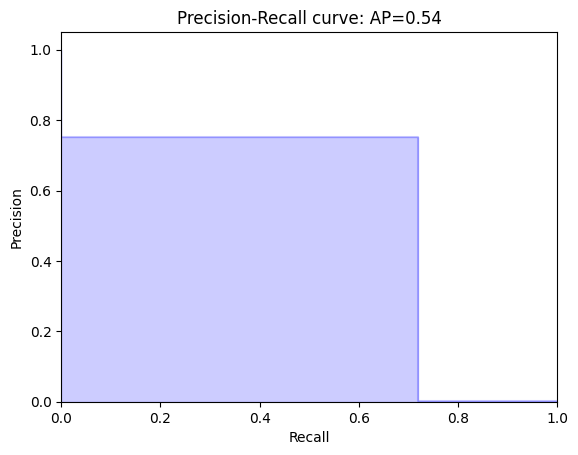

In [12]:
print("decision tree:")

DT_model_a = DecisionTreeClassifier()
DT_model_a, training_time_DT_a = trainHelper(DT_model, x_train, y_train)
f1_DT_a, precision_DT_a, recall_DT_a, inference_time_DT_a  = inferenceHelper(DT_model, x_test, y_test)
auprc_DT_a = plot_PRC(DT_model, x_test, y_test)


2.3 随机森林

Random Forest Classifier
=== train ===
Training time:  0.9154586791992188 sec

=== inference ===
F1 Score:  0.8428246013667426
precision:  0.9585492227979274
recall:  0.7520325203252033
Inference Time: 0.09992027282714844 sec

AUPRC: 0.8471972416971284


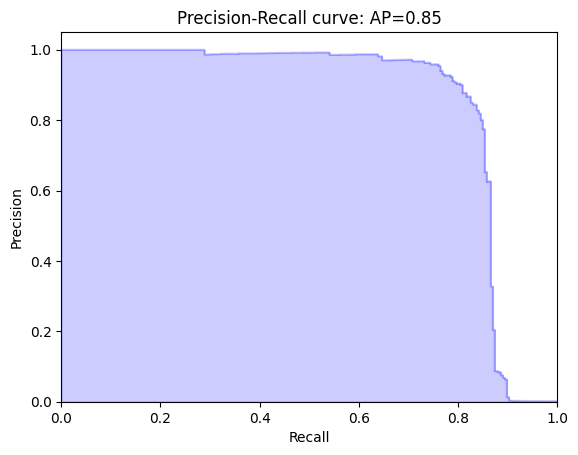

In [13]:
print("Random Forest Classifier")

RF_model = RandomForestClassifier()
RF_model, training_time_RF_a = trainHelper(RF_model, x_train, y_train)
f1_RF_a, precision_RF_a, recall_RF_a, inference_time_RF_a  = inferenceHelper(RF_model, x_test, y_test)
auprc_RF_a = plot_PRC(RF_model, x_test, y_test)

2.4 SVM

Support vector machine
=== train ===
Training time:  493.44880962371826 sec

=== inference ===
F1 Score:  0.8428246013667426
precision:  0.9585492227979274
recall:  0.7520325203252033
Inference Time: 0.10658383369445801 sec

AUPRC: 0.812893159957778


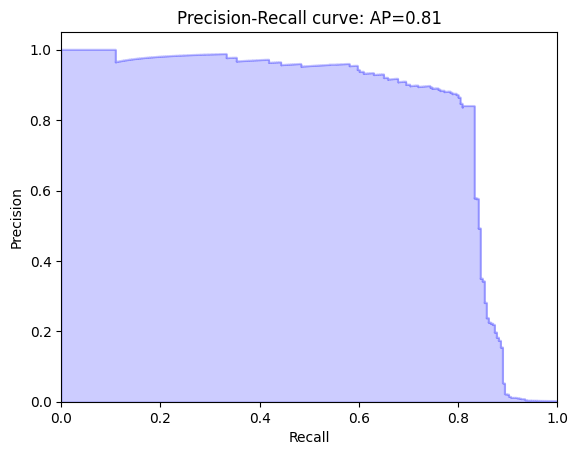

In [14]:
print("Support vector machine")

SVM_model_a = SVC(probability=True)
SVM_model_a, training_time_SVM_a = trainHelper(SVM_model, x_train, y_train)
f1_SVM_a, precision_SVM_a, recall_SVM_a,inference_time_SVM_a  = inferenceHelper(RF_model, x_test, y_test)
auprc_SVM_a = plot_PRC(SVM_model, x_test, y_test)

2.5 KNN

=== train ===
Training time:  0.05930805206298828 sec

=== inference ===
F1 Score:  0.7991071428571428
precision:  0.8861386138613861
recall:  0.7276422764227642
Inference Time: 3.8661892414093018 sec

AUPRC: 0.7650005987999772


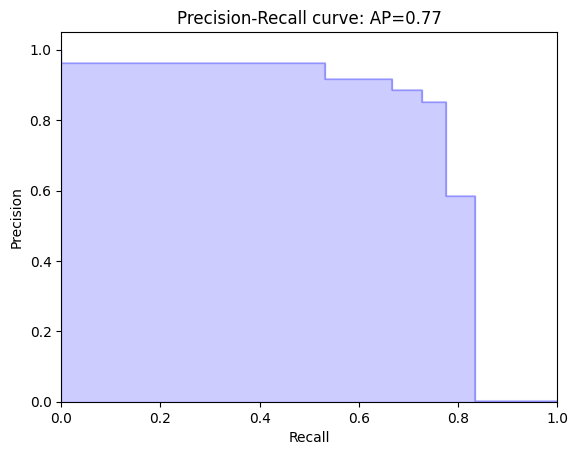

In [15]:
KNN_model = KNeighborsClassifier()
KNN_model, training_time_KNN_a = trainHelper(KNN_model, x_train, y_train)
f1_KNN_a, precision_KNN_a, recall_KNN_a,inference_time_KNN_a  = inferenceHelper(KNN_model, x_test, y_test)
auprc_KNN_a = plot_PRC(KNN_model, x_test, y_test)

# 比较加速后训练指标与未加速的训练指标

In [16]:
# search_time = [search_time_LR, search_time_DT, search_time_RF, search_time_SVM, search_time_KNN]
training_time = [training_time_LR, training_time_DT, training_time_RF, training_time_SVM, training_time_KNN]
inference_time = [inference_time_LR, inference_time_DT, inference_time_RF, inference_time_SVM, inference_time_KNN]
f1 = [f1_LR, f1_DT, f1_RF, f1_SVM, f1_KNN]
precision = [precision_LR, precision_DT, precision_RF,precision_SVM, precision_KNN]
recall = [recall_LR, recall_DT, recall_RF, recall_SVM, recall_KNN]
auprc = [auprc_LR, auprc_DT, auprc_RF, auprc_SVM, auprc_KNN]

# search_time_a = [search_time_LR_a, search_time_DT_a, search_time_RF_a, search_time_SVM_a, search_time_KNN_a]
training_time_a = [training_time_LR_a, training_time_DT_a, training_time_RF_a, training_time_SVM_a, training_time_KNN_a]
inference_time_a = [inference_time_LR_a, inference_time_DT_a, inference_time_RF_a,inference_time_SVM_a, inference_time_KNN_a]
f1_a = [f1_LR_a, f1_DT_a, f1_RF_a, f1_SVM_a, f1_KNN_a]
precision_a = [precision_LR_a, precision_DT_a, precision_RF_a, precision_SVM_a, precision_KNN_a]
recall_a = [recall_LR_a, recall_DT_a, recall_RF_a, recall_SVM_a, recall_KNN_a]
auprc_a = [auprc_LR_a, auprc_DT_a, auprc_RF_a, auprc_SVM_a, auprc_KNN_a]

unit_1 = [1,1,1,1,1]
algorithms = ['LR', 'DT', 'RF', 'SVM', 'KNN']
x = np.arange(len(algorithms))

bar_width = 0.35
opacity = 0.8


训练时间比较

training Time (sec)
Model      origin          oneAPI         
----------------------------------------
LR         1.2786          0.3376         
DT         17.7058         13.1761        
RF         186.4177        0.9155         
SVM        1202.9603       493.4488       
KNN        0.0581          0.0593         


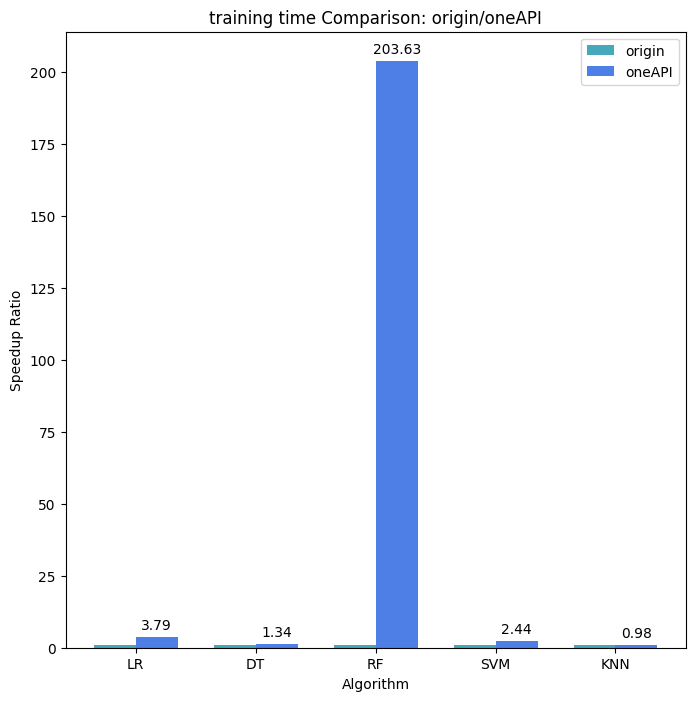

In [17]:
print("training Time (sec)")
printAsTable(training_time, training_time_a)

plotCompareTime("training time", training_time, training_time_a)


推理时间比较


inference Time (sec)
Model      origin          oneAPI         
----------------------------------------
LR         0.0205          0.0071         
DT         0.0221          0.0144         
RF         0.6041          0.0999         
SVM        0.6038          0.1066         
KNN        11.0209         3.8662         


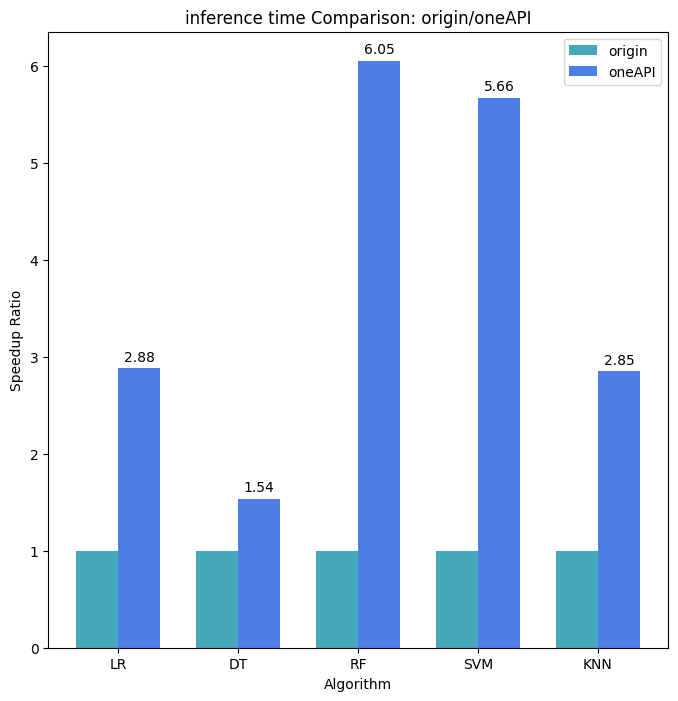

In [18]:
print("inference Time (sec)")
printAsTable(inference_time, inference_time_a)

plotCompareTime("inference time", inference_time, inference_time_a)


AUPRC比较

AUPRC
Model      origin          oneAPI         
----------------------------------------
LR         0.7907          0.7694         
DT         0.5878          0.5424         
RF         0.8612          0.8472         
SVM        0.8438          0.8129         
KNN        0.8210          0.7650         


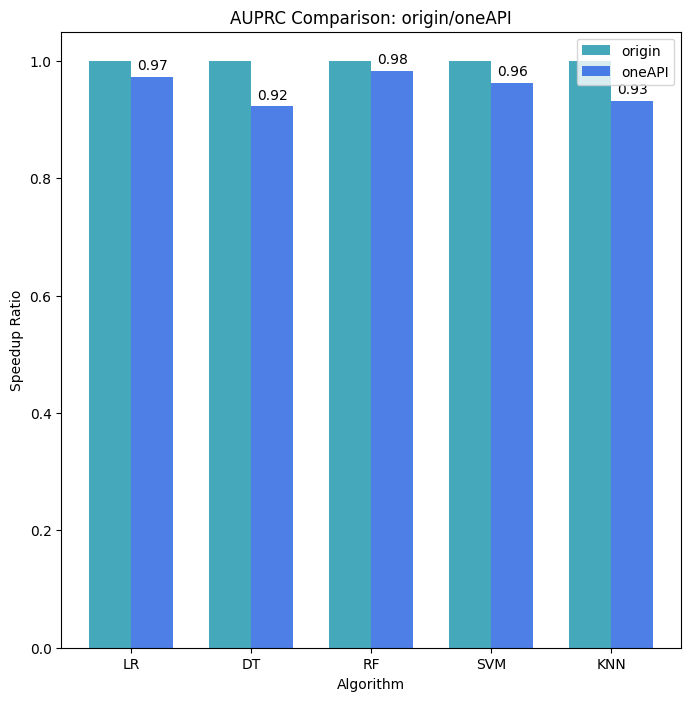

In [19]:
print("AUPRC")
printAsTable(auprc, auprc_a)

plotCompareScore("AUPRC", auprc, auprc_a)


f1 比较

f1 score
Model      origin          oneAPI         
----------------------------------------
LR         0.7296          0.7277         
DT         0.7660          0.7360         
RF         0.8685          0.8428         
SVM        0.8685          0.8428         
KNN        0.8235          0.7991         


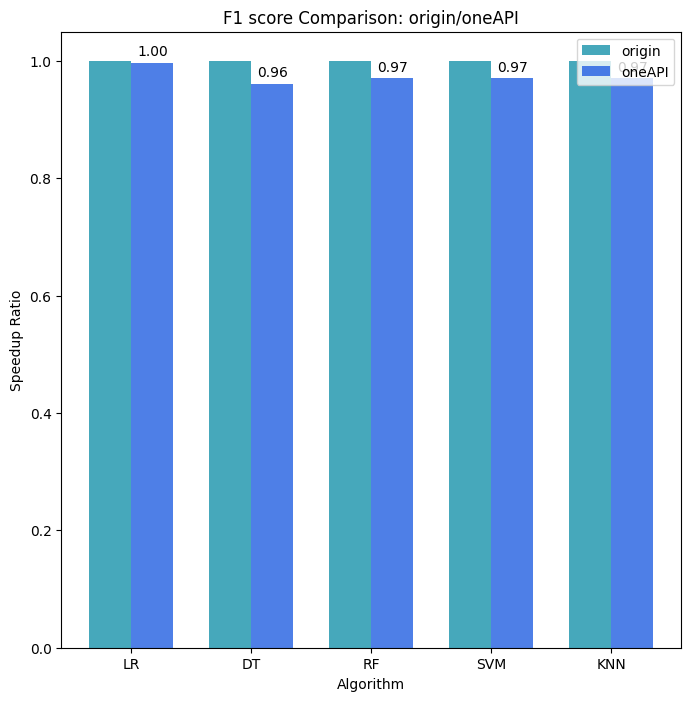

In [20]:
print("f1 score")
printAsTable(f1, f1_a)

plotCompareScore("F1 score", f1, f1_a)


precision 比较

precision
Model      origin          oneAPI         
----------------------------------------
LR         0.8763          0.8935         
DT         0.7397          0.7532         
RF         0.9478          0.9585         
SVM        0.9478          0.9585         
KNN        0.8824          0.8861         


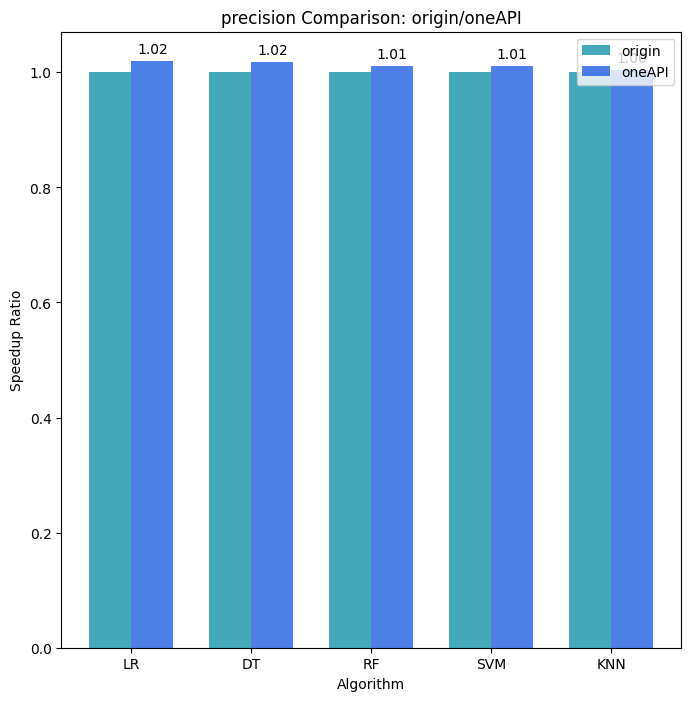

In [21]:
print("precision")
printAsTable(precision, precision_a)

plotCompareScore("precision",precision, precision_a)


recall比较

recall
Model      origin          oneAPI         
----------------------------------------
LR         0.6250          0.6138         
DT         0.7941          0.7195         
RF         0.8015          0.7520         
SVM        0.8015          0.7520         
KNN        0.7721          0.7276         


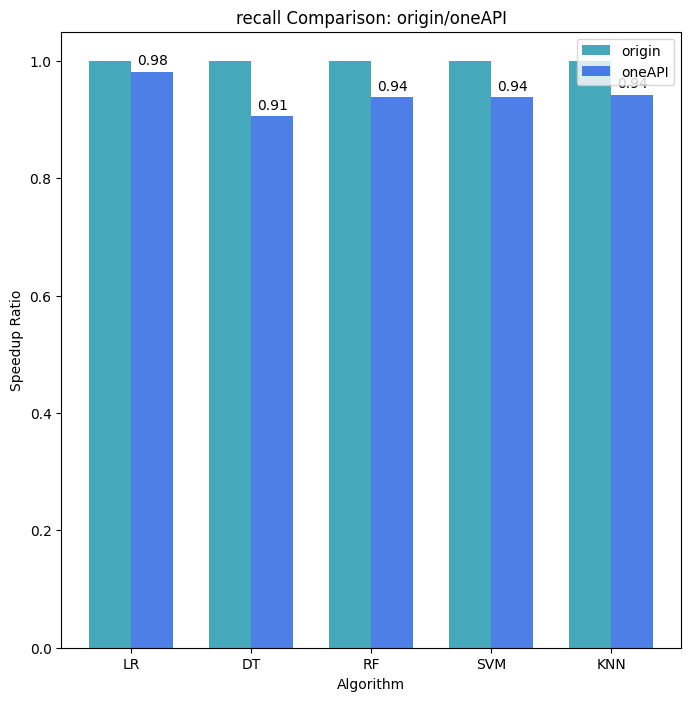

In [22]:
print("recall")
printAsTable(recall, recall_a)

plotCompareScore("recall", recall, recall_a)
